# Long Short Term Memory (LSTM)

LSTM is the king of sequential data and the start of the Transformers. The structure of the LSTM is like the RNN, but with more stuff in his core.

A view of the LSTM module is the below:

<img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/600px-LSTM_Cell.svg.png">

Here, we want to see a simple version of LSTM, so we will use them for a simple classification on MNIST Dataset.

## Import libraries - Prepare the Dataset

In [1]:
!pip install opendatasets

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#"username":"giorgospapadakis227",
#"key":"0d98fada57d63e3b60481c013c67e993"

import opendatasets as od

od.download("https://www.kaggle.com/competitions/digit-recognizer/data", force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: giorgospapadakis227
Your Kaggle Key: ··········


100%|██████████| 15.3M/15.3M [00:00<00:00, 84.4MB/s]


Extracting archive ./digit-recognizer/digit-recognizer.zip to ./digit-recognizer


In [5]:
# load data with pands
train = pd.read_csv('/content/digit-recognizer/train.csv', dtype = np.float32)

# split data into features(pixels) and labels
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255# /255 to normalize the pixels

# split the train dataset into 80% train and test 20%
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

# Create Tensors
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# Basic model parameters
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

## Define LSTM Model

In [4]:
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTMModel,self).__init__()

    # Hidden  dimensions
    self.hidden_dim = hidden_dim

    # Number of hidden layers
    self.layer_dim = layer_dim

    # LSTM
    self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True) # batch_first=True (batch_dim, seq_dim, feature_dim)

    # Readout Layer

    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self,x):
    # Initiate first hidden layer with zeros
    h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

    # Initiate cell state
    c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

    # The input is 28*28. So we will do 28 time steps.
    # So we need to detach as we doing truncated through time (BPTT)
    # If we don't, we'll backprop all the way to the start even after going through another batch

    # Initiate LSTM first pass

    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) # detach h0, c0 from computation at grads

    # out size -> 100, 28, 100
    # # out[:, -1, :] --> 100, 100 --> just want last time step hidden states, no all of them

    out = self.fc(out[:,-1,:])
    return out

In [6]:
# initiate model

input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Train Model

In [7]:
seq_dim = 28
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = error(outputs, labels)

        # Getting gradients
        loss.backward()

        # Updating parameters
        optimizer.step()

        count += 1

        if count % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:

                images = images.view(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            loss_list.append(loss.data.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(count, loss.data.item(), accuracy))

Iteration: 500. Loss: 2.2920753955841064. Accuracy: 14.7619047164917
Iteration: 1000. Loss: 2.2790329456329346. Accuracy: 18.988094329833984
Iteration: 1500. Loss: 1.988998293876648. Accuracy: 36.89285659790039
Iteration: 2000. Loss: 0.967286229133606. Accuracy: 69.54762268066406
Iteration: 2500. Loss: 0.5323244333267212. Accuracy: 83.67857360839844
Iteration: 3000. Loss: 0.2985583245754242. Accuracy: 88.57142639160156
Iteration: 3500. Loss: 0.3605833351612091. Accuracy: 91.39286041259766
Iteration: 4000. Loss: 0.07305718213319778. Accuracy: 93.89286041259766
Iteration: 4500. Loss: 0.14975999295711517. Accuracy: 94.14286041259766
Iteration: 5000. Loss: 0.08320946991443634. Accuracy: 95.30952453613281
Iteration: 5500. Loss: 0.17757363617420197. Accuracy: 95.70237731933594


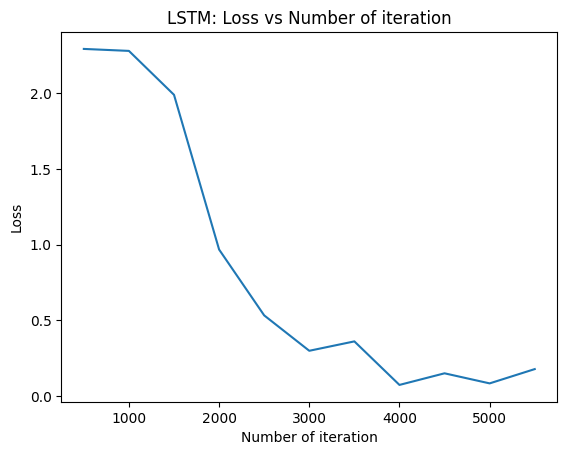

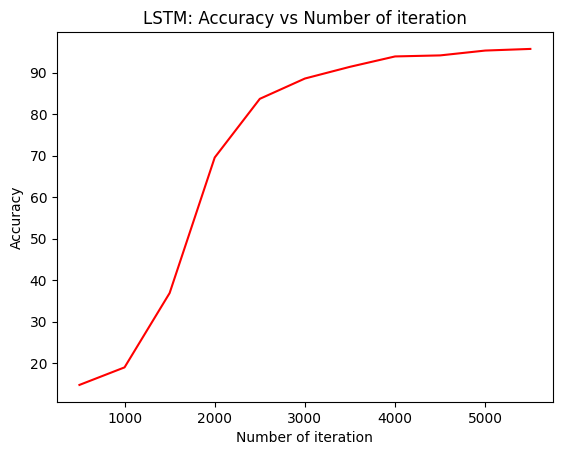

In [8]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("LSTM: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()